In [1]:
# core
import pandas as pd
import numpy as np
import joblib
# reading data
import os
from zipfile import ZipFile
from kaggle.api.kaggle_api_extended import KaggleApi
# visualization
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
# data processing & modeling
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
# custom
from scripts import utils
from scripts.utils import config, evaluate

In [2]:
# Kaggle authentication
api = KaggleApi()
api.authenticate()

## EDA

In [3]:
# download dataset with Kaggle API
api.dataset_download_file('rupakroy/online-payments-fraud-detection-dataset/','PS_20174392719_1491204439457_log.csv')

# designate downloaded file as zip, and unzip
zf = ZipFile('PS_20174392719_1491204439457_log.csv.zip')
zf.extractall()
zf.close()

# read in extracted csv as pandas df
fraud = pd.read_csv('PS_20174392719_1491204439457_log.csv')

# delete downloaded zip and extracted csv - keep your directory clean!
os.remove('PS_20174392719_1491204439457_log.csv.zip')
os.remove('PS_20174392719_1491204439457_log.csv')

print(fraud.shape)

fraud.head()

(6362620, 11)


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


### Column Descriptions

The below column reference:

1. step: represents a unit of time where 1 step equals 1 hour
2. type: type of online transaction
3. amount: the amount of the transaction
4. nameOrig: customer starting the transaction
5. oldbalanceOrg: balance before the transaction
6. newbalanceOrig: balance after the transaction
7. nameDest: recipient of the transaction
8. oldbalanceDest: initial balance of recipient before the transaction
9. newbalanceDest: the new balance of recipient after the transaction
10. isFraud: fraud transaction

In [4]:
for col in fraud.columns:
    print(f'{col} - Dtype: {fraud[col].dtype} - Unique: {fraud[col].nunique()}')

step - Dtype: int64 - Unique: 743
type - Dtype: object - Unique: 5
amount - Dtype: float64 - Unique: 5316900
nameOrig - Dtype: object - Unique: 6353307
oldbalanceOrg - Dtype: float64 - Unique: 1845844
newbalanceOrig - Dtype: float64 - Unique: 2682586
nameDest - Dtype: object - Unique: 2722362
oldbalanceDest - Dtype: float64 - Unique: 3614697
newbalanceDest - Dtype: float64 - Unique: 3555499
isFraud - Dtype: int64 - Unique: 2
isFlaggedFraud - Dtype: int64 - Unique: 2


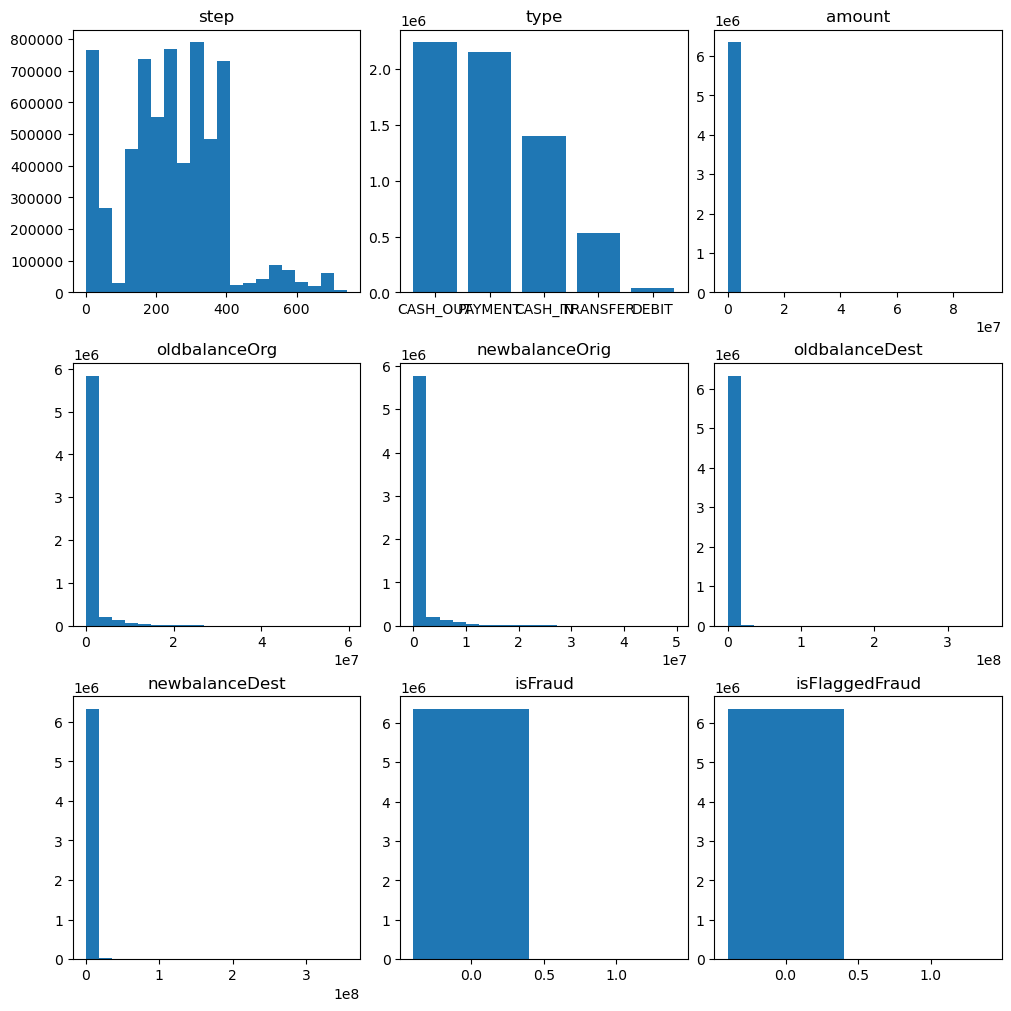

In [5]:
numerical_features = ['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']
categorical_features = ['type', 'nameOrig', 'nameDest', 'isFraud', 'isFlaggedFraud']

fig, axes = plt.subplots(3, 3, figsize=(10, 10), layout='constrained')
cols_to_plot = [x for x in fraud.columns if x != 'nameOrig' and x != 'nameDest']

for col, ax in zip(cols_to_plot, axes.ravel()):
    if col in numerical_features:
        ax.hist(fraud[col], bins=20)
        ax.set_title(col)
    else:
        ax.bar(fraud[col].value_counts().index, fraud[col].value_counts().values)
        ax.set_title(col)

plt.show()

In [6]:
f'Percentage of fraudulent transactions: {fraud[fraud["isFraud"] == 1].shape[0] / fraud.shape[0]:.2%}'

'Percentage of fraudulent transactions: 0.13%'

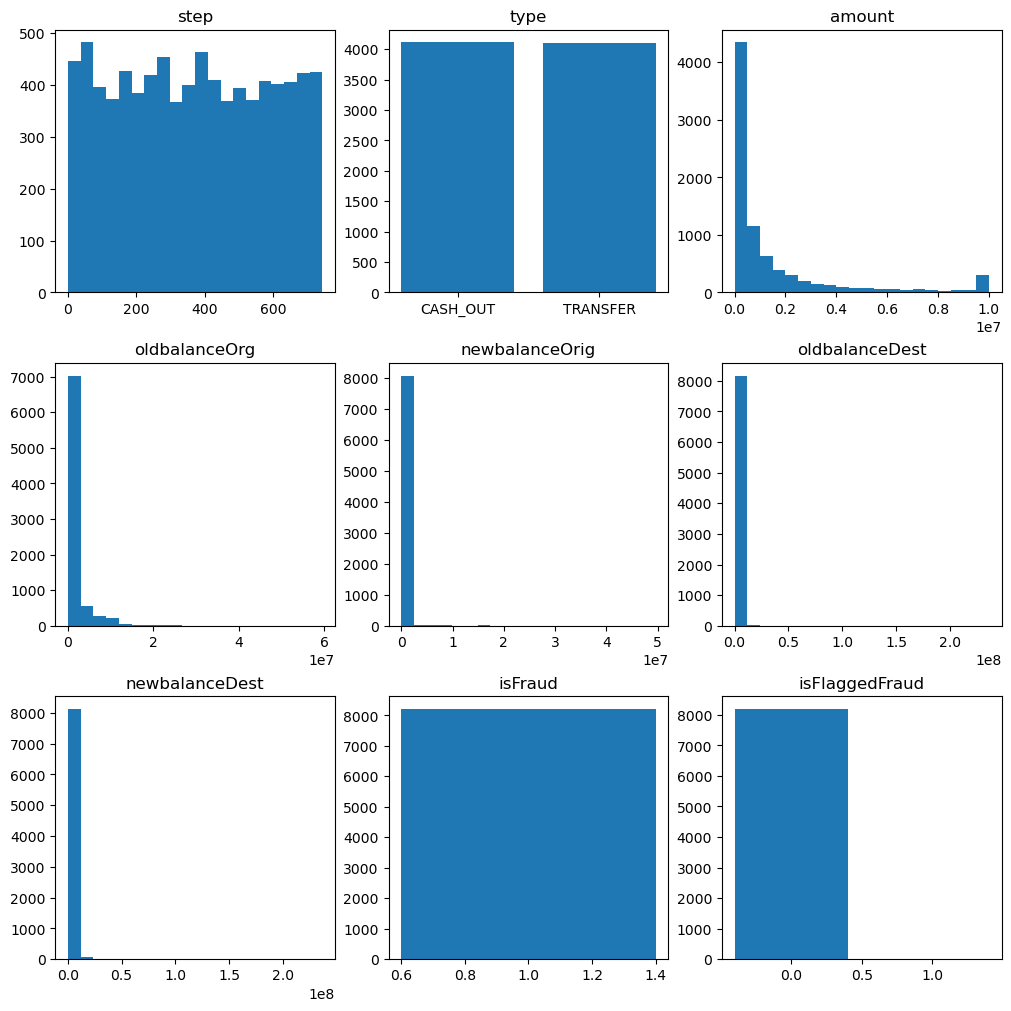

In [7]:
fig, axes = plt.subplots(3, 3, figsize=(10, 10), layout='constrained')
fraud_filterd = fraud[fraud['isFraud'] == 1]

for col, ax in zip(cols_to_plot, axes.ravel()):
    if col in numerical_features:
        ax.hist(fraud_filterd[col], bins=20)
        ax.set_title(col)
    else:
        ax.bar(fraud_filterd[col].value_counts().index, fraud_filterd[col].value_counts().values)
        ax.set_title(col)

plt.show()

# Preprocessing

In [8]:
%run scripts/preprocess.py


-- Config -- 

RANDOM_SEED: 42
TRAIN_SIZE: 0.8
SHUFFLE: True
STRATIFY: True
FEATURES_TO_REMOVE: ['nameOrig', 'nameDest', 'isFlaggedFraud']
FEATURES_TO_SCALE: ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']
FEATURES_TO_ENCODE: ['type']
SCALER: <class 'sklearn.preprocessing._data.StandardScaler'>
Initial shape: (6362620, 11)

-- Train, Valid, Test Split --

Features
Train: (5090096, 9) - Valid: (636262, 9) - Test (636262, 9)

Labels
Train: (5090096,) - Valid: (636262,) - Test (636262,)

Time Elapsed: 0.23 min


-- Scaling / Encoding --

Features to encode: ['type']
Features to scale: ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']

Train: (5090096, 10) - Valid: (636262, 10) - Test (636262, 10)

Time Elapsed: 0.25 min

Preprocessing Complete. Time Elapsed: 0.26 min


# Baseline Training

In [9]:
%run scripts/train.py


-- Config -- 

RANDOM_SEED: 42
TRAIN_SIZE: 0.8
SHUFFLE: True
STRATIFY: True
FEATURES_TO_REMOVE: ['nameOrig', 'nameDest', 'isFlaggedFraud']
FEATURES_TO_SCALE: ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']
FEATURES_TO_ENCODE: ['type']
SCALER: <class 'sklearn.preprocessing._data.StandardScaler'>

-- Fitting DecisionTreeClassifier --

Train Accuracy: 1.00
Train Precision: 1.00
Train Recall: 1.00
Train F1: 1.00

Train Accuracy: 1.00
Train Precision: 0.91
Train Recall: 0.91
Train F1: 0.91

Time Elapsed: 0.40 min


-- Fitting RandomForestClassifier --

Train Accuracy: 1.00
Train Precision: 1.00
Train Recall: 1.00
Train F1: 1.00

Train Accuracy: 1.00
Train Precision: 0.96
Train Recall: 0.79
Train F1: 0.86

Time Elapsed: 1.30 min


-- Fitting XGBClassifier --

Train Accuracy: 1.00
Train Precision: 0.97
Train Recall: 0.80
Train F1: 0.88

Train Accuracy: 1.00
Train Precision: 0.95
Train Recall: 0.77
Train F1: 0.85

Time Elapsed: 1.46 min

Training Complete - 1

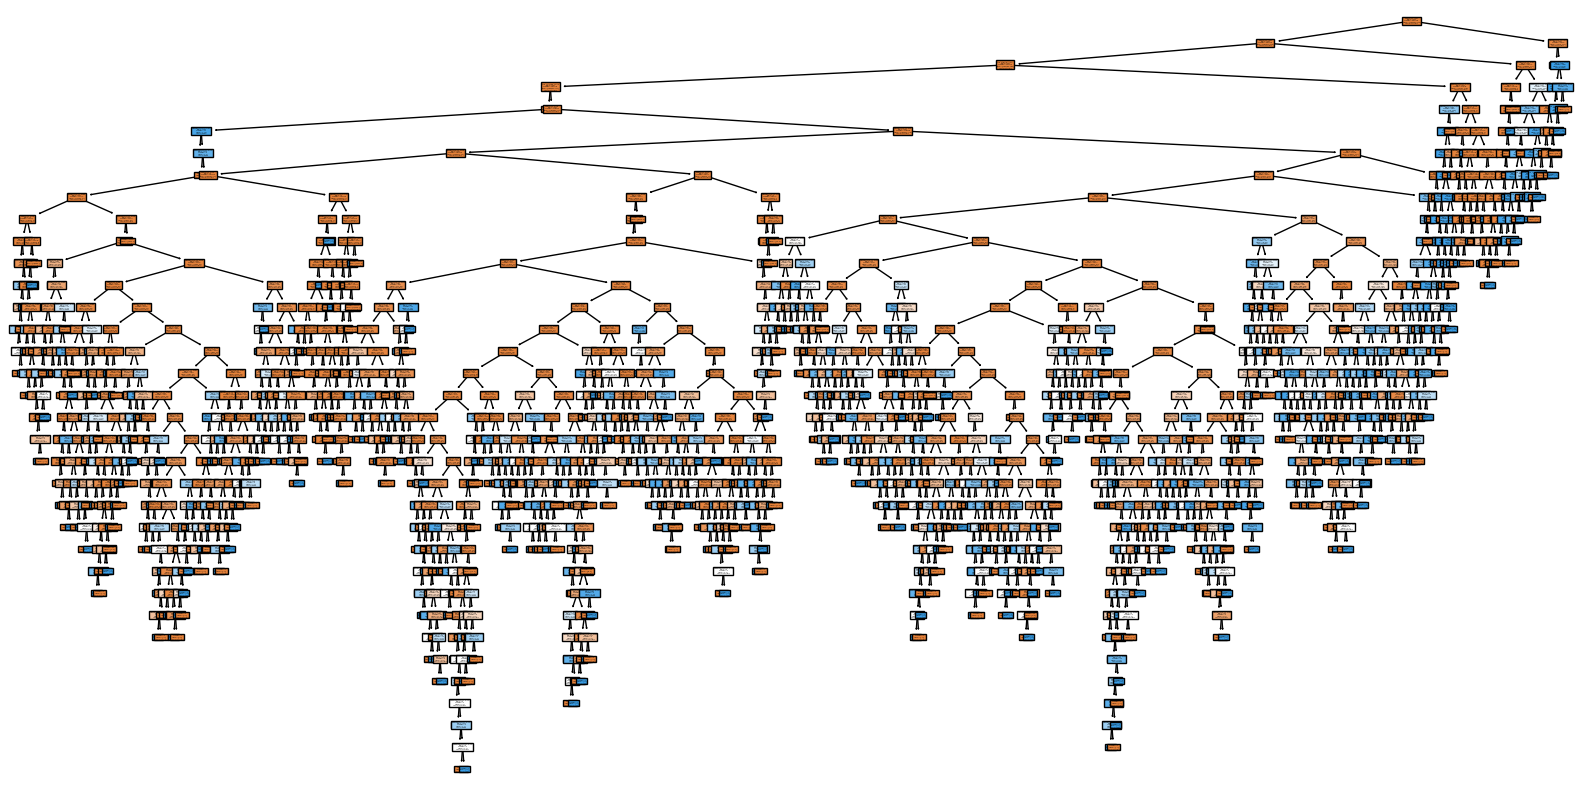

In [10]:
encoded_features = []
for category in fraud.type.unique():
    encoded_features.append(f'type_{category}')

features = encoded_features + config['FEATURES_TO_SCALE']
classes = ['Not Fraud', 'Fraud']

dt = joblib.load('models/dt.joblib')
plt.figure(figsize=(20,10))
plot_tree(dt, filled=True, feature_names=features, class_names=classes)
plt.show()

# Alternate Decision Tree

In [11]:
X_train = np.load('data/processed/X_train.npy')
y_train = np.load('data/processed/y_train.npy')

X_train, X_drop, y_train, y_drop = train_test_split(
    X_train, y_train, test_size=0.4, random_state=42,
    shuffle=True, stratify=y_train
)

np.save('data/processed/X_train.npy', X_train)
np.save('data/processed/y_train.npy', y_train)

print(
    f'Reduced training set size: {X_train.shape} - {y_train.shape}'
    f'\nPercentage of fraudulent transactions: {y_train.sum() / y_train.shape[0]:.2%}'
)

Reduced training set size: (3054057, 10) - (3054057,)


In [12]:
%run scripts/train.py


-- Config -- 

RANDOM_SEED: 42
TRAIN_SIZE: 0.8
SHUFFLE: True
STRATIFY: True
FEATURES_TO_REMOVE: ['nameOrig', 'nameDest', 'isFlaggedFraud']
FEATURES_TO_SCALE: ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']
FEATURES_TO_ENCODE: ['type']
SCALER: <class 'sklearn.preprocessing._data.StandardScaler'>

-- Fitting DecisionTreeClassifier --

Train Accuracy: 1.00
Train Precision: 1.00
Train Recall: 1.00
Train F1: 1.00

Train Accuracy: 1.00
Train Precision: 0.88
Train Recall: 0.87
Train F1: 0.87

Time Elapsed: 0.16 min


-- Fitting RandomForestClassifier --

Train Accuracy: 1.00
Train Precision: 1.00
Train Recall: 1.00
Train F1: 1.00

Train Accuracy: 1.00
Train Precision: 0.96
Train Recall: 0.76
Train F1: 0.85

Time Elapsed: 0.47 min


-- Fitting XGBClassifier --

Train Accuracy: 1.00
Train Precision: 0.98
Train Recall: 0.82
Train F1: 0.90

Train Accuracy: 1.00
Train Precision: 0.94
Train Recall: 0.76
Train F1: 0.84

Time Elapsed: 0.53 min

Training Complete - 0

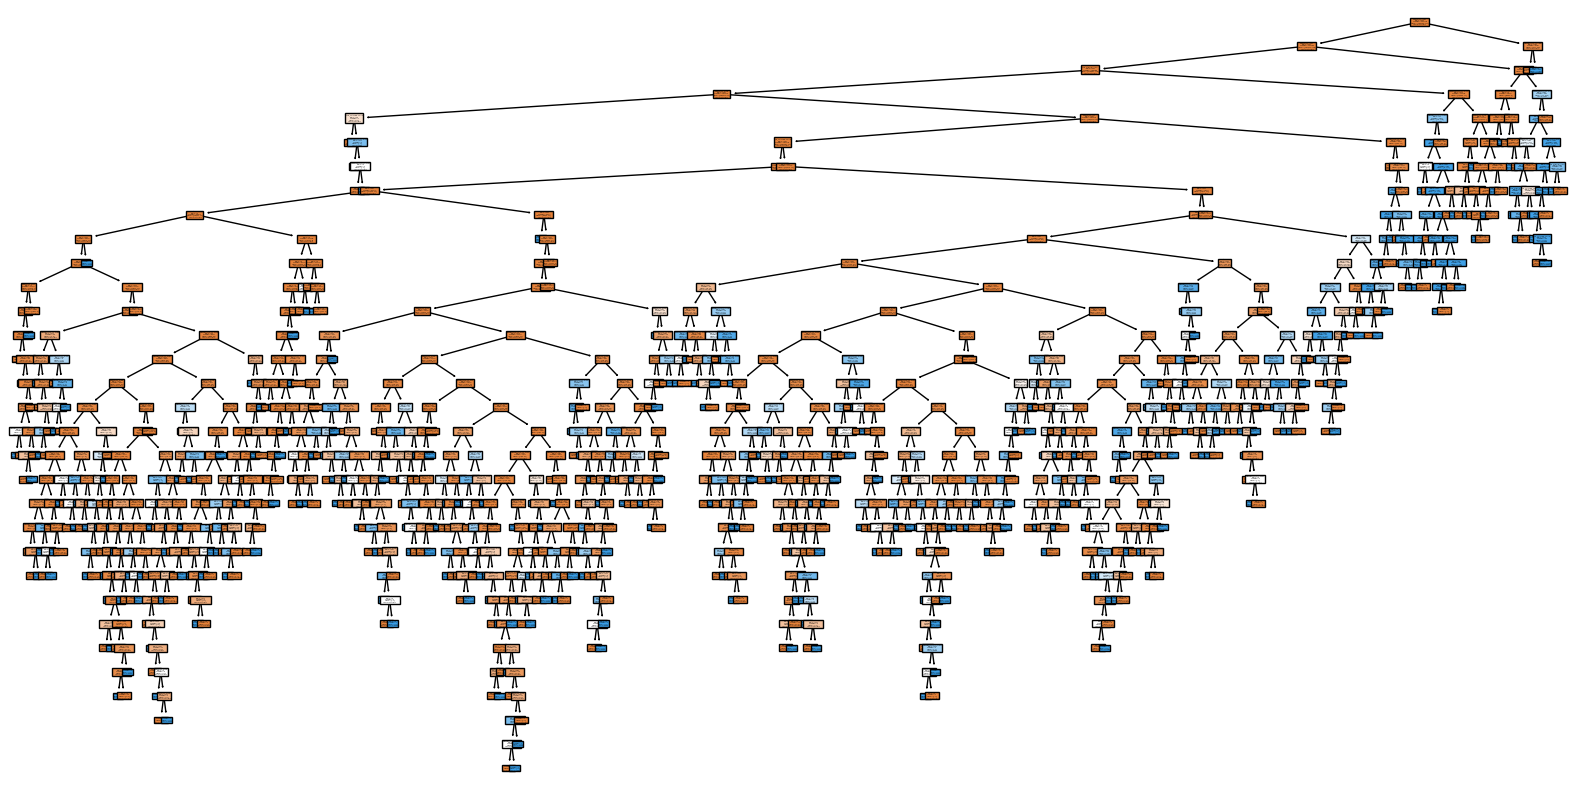

In [13]:
encoded_features = []
for category in fraud.type.unique():
    encoded_features.append(f'type_{category}')

features = encoded_features + config['FEATURES_TO_SCALE']
classes = ['Not Fraud', 'Fraud']

dt = joblib.load('models/dt.joblib')
plt.figure(figsize=(20,10))
plot_tree(dt, filled=True, feature_names=features, class_names=classes)
plt.show()

## Tuning

In [14]:
%run scripts/preprocess.py
%run scripts/tuning.py 


-- Config -- 

RANDOM_SEED: 42
TRAIN_SIZE: 0.8
SHUFFLE: True
STRATIFY: True
FEATURES_TO_REMOVE: ['nameOrig', 'nameDest', 'isFlaggedFraud']
FEATURES_TO_SCALE: ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']
FEATURES_TO_ENCODE: ['type']
SCALER: <class 'sklearn.preprocessing._data.StandardScaler'>
Initial shape: (6362620, 11)

-- Train, Valid, Test Split --

Features
Train: (5090096, 9) - Valid: (636262, 9) - Test (636262, 9)

Labels
Train: (5090096,) - Valid: (636262,) - Test (636262,)

Time Elapsed: 0.24 min


-- Scaling / Encoding --

Features to encode: ['type']
Features to scale: ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']

Train: (5090096, 10) - Valid: (636262, 10) - Test (636262, 10)

Time Elapsed: 0.26 min

Preprocessing Complete. Time Elapsed: 0.27 min

-- Config -- 

RANDOM_SEED: 42
TRAIN_SIZE: 0.8
SHUFFLE: True
STRATIFY: True
FEATURES_TO_REMOVE: ['nameOrig', 'nameDest', 'isFlaggedFraud']
FEATURES_TO_SCALE:

In [ ]:
dt_results = pd.read_excel('logs/tuning_results_04.01_11.11.xlsx', engine='openpyxl', index_col=0, sheet_name='dt')
rf_results = pd.read_excel('logs/tuning_results_04.01_11.11.xlsx', engine='openpyxl', index_col=0, sheet_name='rf')
xgb_results = pd.read_excel('logs/tuning_results_04.01_11.11.xlsx', engine='openpyxl', index_col=0, sheet_name='xgb')

display(
    dt_results.sort_values(by='valid_f1', ascending=False).head(10),
    rf_results.sort_values(by='valid_f1', ascending=False).head(10),
    xgb_results.sort_values(by='valid_f1', ascending=False).head(10)
)

,model,train_accuracy,train_precision,train_recall,train_f1,valid_accuracy,valid_precision,valid_recall,valid_f1,criterion,max_depth,max_features,min_samples_leaf,min_samples_split,random_state,splitter
8,dt,0.999929,0.987742,0.956722,0.971984,0.999701,0.908269,0.855231,0.880952,gini,NaN,1,2,5,42,best
170,dt,0.999929,0.987742,0.956722,0.971984,0.999701,0.908269,0.855231,0.880952,gini,30.0,1,2,5,42,best
6,dt,0.999935,0.992448,0.956339,0.974059,0.999695,0.907792,0.850365,0.878141,gini,NaN,1,2,2,42,best
168,dt,0.999935,0.992448,0.956339,0.974059,0.999695,0.907792,0.850365,0.878141,gini,30.0,1,2,2,42,best
380,dt,0.999959,0.989539,0.978169,0.983821,0.999686,0.889724,0.863747,0.876543,entropy,30.0,1,1,5,42,best
218,dt,0.999959,0.989539,0.978169,0.983821,0.999686,0.889724,0.863747,0.876543,entropy,NaN,1,1,5,42,best
172,dt,0.999889,0.972641,0.939487,0.955776,0.999686,0.895674,0.856448,0.875622,gini,30.0,1,2,10,42,best
10,dt,0.999889,0.972641,0.939487,0.955776,0.999686,0.895674,0.856448,0.875622,gini,NaN,1,2,10,42,best
116,dt,0.999873,0.985149,0.914592,0.948560,0.999692,0.919571,0.834550,0.875000,gini,20.0,1,2,5,42,best
384,dt,0.999943,0.993666,0.961318,0.977224,0.999686,0.901809,0.849148,0.874687,entropy,30.0,1,2,2,42,best


,model,train_accuracy,train_precision,train_recall,train_f1,valid_accuracy,valid_precision,valid_recall,valid_f1,criterion,max_depth,max_features,n_estimators,n_jobs,random_state
65,rf,1.000000,1.0,1.000000,1.000000,0.999701,0.922460,0.839416,0.878981,entropy,30.0,1,200,-1,42
38,rf,1.000000,1.0,1.000000,1.000000,0.999701,0.922460,0.839416,0.878981,entropy,NaN,1,200,-1,42
37,rf,1.000000,1.0,1.000000,1.000000,0.999701,0.923592,0.838200,0.878827,entropy,NaN,1,100,-1,42
56,rf,0.999984,1.0,0.987361,0.993640,0.999701,0.928184,0.833333,0.878205,entropy,20.0,1,200,-1,42
36,rf,0.999999,1.0,0.998851,0.999425,0.999700,0.923490,0.836983,0.878111,entropy,NaN,1,50,-1,42
63,rf,0.999999,1.0,0.998851,0.999425,0.999700,0.923490,0.836983,0.878111,entropy,30.0,1,50,-1,42
27,rf,0.999998,1.0,0.998085,0.999042,0.999703,0.938974,0.823601,0.877511,gini,30.0,1,50,-1,42
55,rf,0.999981,1.0,0.985063,0.992475,0.999701,0.934066,0.827251,0.877419,entropy,20.0,1,100,-1,42
64,rf,1.000000,1.0,1.000000,1.000000,0.999698,0.923387,0.835766,0.877395,entropy,30.0,1,100,-1,42
54,rf,0.999976,1.0,0.981233,0.990528,0.999700,0.931601,0.828467,0.877012,entropy,20.0,1,50,-1,42


,model,train_accuracy,train_precision,train_recall,train_f1,valid_accuracy,valid_precision,valid_recall,valid_f1,gamma,learning_rate,max_depth,n_estimators,n_jobs,random_state,subsample
232,xgb,0.999755,0.976105,0.829184,0.896666,0.999639,0.939169,0.770073,0.846257,1.0,0.2,6,200,-1,42,0.8
231,xgb,0.999775,0.976106,0.844887,0.905769,0.999637,0.937778,0.770073,0.845691,1.0,0.2,6,200,-1,42,0.6
154,xgb,0.999743,0.977574,0.818077,0.890742,0.999635,0.936391,0.770073,0.845127,0.5,0.2,10,50,-1,42,0.8
44,xgb,0.999718,0.984308,0.792800,0.878235,0.999642,0.958333,0.755474,0.844898,0.1,0.1,6,200,-1,42,1.0
71,xgb,0.999764,0.984973,0.828418,0.899938,0.999637,0.944361,0.763990,0.844654,0.1,0.2,6,200,-1,42,1.0
229,xgb,0.999717,0.978363,0.796630,0.878193,0.999639,0.949848,0.760341,0.844595,1.0,0.2,6,100,-1,42,0.8
147,xgb,0.999721,0.979343,0.798928,0.879983,0.999639,0.956790,0.754258,0.843537,0.5,0.2,6,100,-1,42,0.6
238,xgb,0.999759,0.973637,0.834546,0.898742,0.999631,0.932253,0.770073,0.843438,1.0,0.2,10,100,-1,42,0.8
53,xgb,0.999804,0.983392,0.861739,0.918555,0.999631,0.932253,0.770073,0.843438,0.1,0.1,10,200,-1,42,1.0
204,xgb,0.999721,0.982067,0.797013,0.879915,0.999637,0.953917,0.755474,0.843177,1.0,0.1,6,200,-1,42,0.6


Final Run with Full Data and Optimal Hyperparameters

In [ ]:
utils.hyperparams = {
    'dt': {
        'criterion': 'gini',
        'splitter': 'best',
        'max_depth': None,
        'min_samples_split': 5,
        'min_samples_leaf': 2,
        'max_features': 1.0,
        'random_state': config['RANDOM_SEED']
    },
    'rf': {
        'n_estimators': 200,
        'criterion': 'entropy',
        'max_depth': None,
        'max_features': 1.0,
        'random_state': config['RANDOM_SEED'],
        'n_jobs': -1
    },
    'xgb': {
        'n_estimators': 200,
        'max_depth': 10,
        'learning_rate': 0.2,
        'subsample': 0.8,
        'gamma': 1,
        'random_state': config['RANDOM_SEED'],
        'n_jobs': -1
    }
}

%run scripts/preprocess.py
%run scripts/train.py


-- Config -- 

RANDOM_SEED: 42
TRAIN_SIZE: 0.8
SHUFFLE: True
STRATIFY: True
FEATURES_TO_REMOVE: ['nameOrig', 'nameDest', 'isFlaggedFraud']
FEATURES_TO_SCALE: ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']
FEATURES_TO_ENCODE: ['type']
SCALER: <class 'sklearn.preprocessing._data.StandardScaler'>
Initial shape: (6362620, 11)

-- Train, Valid, Test Split --

Features
Train: (5090096, 9) - Valid: (636262, 9) - Test (636262, 9)

Labels
Train: (5090096,) - Valid: (636262,) - Test (636262,)

Time Elapsed: 0.24 min


-- Scaling / Encoding --

Features to encode: ['type']
Features to scale: ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']

Train: (5090096, 10) - Valid: (636262, 10) - Test (636262, 10)

Time Elapsed: 0.26 min

Preprocessing Complete. Time Elapsed: 0.26 min

-- Config -- 

RANDOM_SEED: 42
TRAIN_SIZE: 0.8
SHUFFLE: True
STRATIFY: True
FEATURES_TO_REMOVE: ['nameOrig', 'nameDest', 'isFlaggedFraud']
FEATURES_TO_SCALE:

In [ ]:
X_train = np.load('data/processed/X_train.npy')
y_train = np.load('data/processed/y_train.npy')

X_valid = np.load('data/processed/X_valid.npy')
y_valid = np.load('data/processed/y_valid.npy')

X_train = np.concatenate([X_train, X_valid])
y_train = np.concatenate([y_train, y_valid])

X_test = np.load('data/processed/X_test.npy')
y_test = np.load('data/processed/y_test.npy')

print(
    f'Final training set size: {X_train.shape} - {y_train.shape}'
    f'\nFinal test set size: {X_test.shape} - {y_test.shape}'
)

Final training set size: (5726358, 10) - (5726358,)Final test set size: (636262, 10) - (636262,)


In [ ]:
dt = DecisionTreeClassifier(**utils.hyperparams['dt'])
rf = RandomForestClassifier(**utils.hyperparams['rf'])
xgb = XGBClassifier(**utils.hyperparams['xgb'])

models = [dt, rf, xgb]
summary = pd.DataFrame()

for model in models:
    print(f'\n-- Fitting {model.__class__.__name__} --\n')
    # Train model
    model.fit(X_train, y_train)
    # Get evaluation metrics
    train_accuracy, train_precision, train_recall, train_f1 = evaluate(model, X_train, y_train)
    test_accuracy, test_precision, test_recall, test_f1 = evaluate(model, X_test, y_test)
    # Log results
    result = pd.DataFrame({
        'model': model.__class__.__name__,
        'train_accuracy': train_accuracy,
        'train_precision': train_precision,
        'train_recall': train_recall,
        'train_f1': train_f1,
        'test_accuracy': test_accuracy,
        'test_precision': test_precision,
        'test_recall': test_recall,
        'test_f1': test_f1
    }, index=[0])
    summary = pd.concat([summary, result], ignore_index=True)


-- Fitting DecisionTreeClassifier --

Train Accuracy: 1.00
Train Precision: 1.00
Train Recall: 1.00
Train F1: 1.00

Train Accuracy: 1.00
Train Precision: 0.90
Train Recall: 0.91
Train F1: 0.90


-- Fitting RandomForestClassifier --

Train Accuracy: 1.00
Train Precision: 1.00
Train Recall: 1.00
Train F1: 1.00

Train Accuracy: 1.00
Train Precision: 0.97
Train Recall: 0.79
Train F1: 0.87


-- Fitting XGBClassifier --

Train Accuracy: 1.00
Train Precision: 0.98
Train Recall: 0.79
Train F1: 0.87

Train Accuracy: 1.00
Train Precision: 0.96
Train Recall: 0.78
Train F1: 0.86

